<a href="https://colab.research.google.com/github/ViRuS79Pro/Rice-Type-Classification-using-ANN/blob/main/RiceTypeClassificationANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download ("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sibasundarmanik
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


In [3]:
df=pd.read_csv('/content/rice-type-classification/riceClassification.csv')

In [4]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
df.drop(columns=['id'], inplace=True)
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
device='cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [7]:
column_names=list(df.columns)

In [8]:
for i in column_names:
    print((df[i]<0).value_counts())

Area
False    18185
Name: count, dtype: int64
MajorAxisLength
False    18185
Name: count, dtype: int64
MinorAxisLength
False    18185
Name: count, dtype: int64
Eccentricity
False    18185
Name: count, dtype: int64
ConvexArea
False    18185
Name: count, dtype: int64
EquivDiameter
False    18185
Name: count, dtype: int64
Extent
False    18185
Name: count, dtype: int64
Perimeter
False    18185
Name: count, dtype: int64
Roundness
False    18185
Name: count, dtype: int64
AspectRation
False    18185
Name: count, dtype: int64
Class
False    18185
Name: count, dtype: int64


In [9]:
for i in column_names:
    df[i]=df[i]/df[i].max()

In [10]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [11]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=79)
X_train.shape, y_train.shape

((12729, 10), (12729,))

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=79)
X_val.shape, X_test.shape

((2728, 10), (2728, 10))

In [14]:
## Convert into separate Datasets (convert to tensors, datatype torch tensor 32 and device)
class dataset(Dataset):
    def __init__(self, X, y):
        self.X=torch.tensor(X.values, dtype=torch.float32).to(device)
        self.y=torch.tensor(y.values, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [15]:
train_dataset=dataset(X_train, y_train)
val_dataset=dataset(X_val, y_val)
test_dataset=dataset(X_test, y_test)

In [16]:
## Create Batches using Dataloaders
train_DL=DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_DL=DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)
val_DL=DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

In [17]:
for X, y in val_DL:
    print(X)
    print(y)
    break

tensor([[0.7134, 0.7950, 0.7859, 0.9261, 0.6738, 0.8446, 0.7418, 0.6784, 0.8502,
         0.5739],
        [0.7589, 0.7843, 0.8460, 0.9040, 0.7260, 0.8711, 0.6579, 0.6915, 0.8704,
         0.5260],
        [0.7537, 0.8374, 0.7849, 0.9376, 0.7230, 0.8681, 0.6359, 0.7087, 0.8228,
         0.6053],
        [0.7079, 0.8674, 0.7095, 0.9615, 0.6746, 0.8414, 0.7735, 0.7125, 0.7648,
         0.6936],
        [0.6282, 0.8755, 0.6368, 0.9772, 0.6084, 0.7926, 0.5092, 0.7100, 0.6835,
         0.7800],
        [0.6075, 0.7981, 0.6607, 0.9597, 0.5766, 0.7794, 0.5800, 0.6524, 0.7829,
         0.6853],
        [0.5466, 0.8531, 0.5600, 0.9881, 0.5303, 0.7393, 0.8450, 0.6705, 0.6668,
         0.8642],
        [0.7700, 0.8158, 0.8216, 0.9217, 0.7274, 0.8775, 0.6860, 0.6977, 0.8676,
         0.5633],
        [0.5010, 0.7952, 0.5557, 0.9817, 0.4782, 0.7078, 0.5410, 0.6275, 0.6977,
         0.8118],
        [0.6117, 0.8773, 0.6107, 0.9822, 0.5798, 0.7821, 0.5077, 0.6946, 0.6953,
         0.8150],
        [0

In [18]:
(X.shape)[1]

10

In [19]:
## ANN
class RiceNET(nn.Module):
    def __init__(self):
        super(RiceNET, self).__init__()
        self.seq=nn.Sequential(nn.Linear(in_features=X.shape[1], out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid())

    def forward(self, X):
        return self.seq(X)

In [36]:
model=RiceNET()
model.to(device)

RiceNET(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [37]:
summary(model, input_size=(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             352
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 16]             528
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 1]              17
           Sigmoid-6                    [-1, 1]               0
Total params: 897
Trainable params: 897
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [38]:
## Setting up Loss Function and Optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [39]:
epochs=30
train_loss=[]
val_loss=[]
torch.manual_seed(79)
for epoch in range(epochs):
    model.train()
    batch_losses_train=[]
    batch_losses_val=[]
    for X, y in train_DL:
        y_pred=model(X)
        batch_loss=loss_fn(y_pred.squeeze(), y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        batch_losses_train.append(batch_loss.item())
    model.eval()
    with torch.inference_mode():
        for X, y in val_DL:
            y_pred=model(X)
            batch_loss=loss_fn(y_pred.squeeze(), y)
            batch_losses_val.append(batch_loss.item())
    train_loss.append(np.array(batch_losses_train).mean())
    val_loss.append(np.array(batch_losses_val).mean())

In [40]:
val_loss

[np.float64(61.850476542184516),
 np.float64(60.87691973530969),
 np.float64(59.35510451294655),
 np.float64(58.26234607918318),
 np.float64(57.69953395045081),
 np.float64(57.39336393045824),
 np.float64(57.25721888209498),
 np.float64(57.097984979319016),
 np.float64(57.056055246397506),
 np.float64(57.0128009485644),
 np.float64(57.01439624608949),
 np.float64(56.979163247485495),
 np.float64(56.92484365507614),
 np.float64(56.985900590586105),
 np.float64(56.99429027978764),
 np.float64(56.85597952022109),
 np.float64(56.87653426236884),
 np.float64(56.82935672582582),
 np.float64(56.85879211647566),
 np.float64(56.82206892412762),
 np.float64(56.8630288146263),
 np.float64(56.86336161923963),
 np.float64(56.834559717843696),
 np.float64(56.785143031630405),
 np.float64(56.8663207375726),
 np.float64(56.95494794013889),
 np.float64(56.80644756139711),
 np.float64(56.86927825351094),
 np.float64(56.84056192220643),
 np.float64(56.86013194294863)]

<ipython-input-41-465e373d86dd>:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


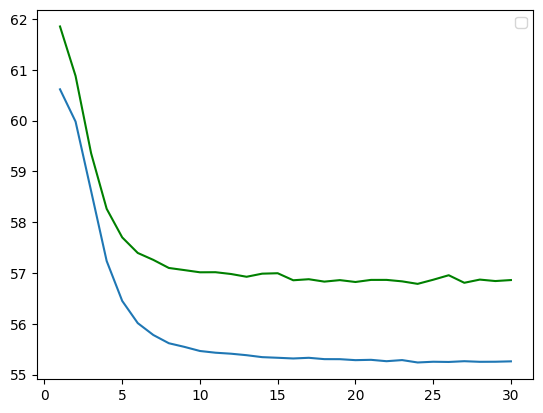

In [41]:
plt.plot([i for i in range(1,epochs+1)],val_loss ,color='green')
plt.plot([i for i in range(1,epochs+1)],train_loss)
plt.legend()

In [71]:
model.eval()
tot=X_test.shape[0]
trues=0
with torch.inference_mode():
    for X, y in test_DL:
        y_pred=model(X).squeeze()
        trues+=(y_pred.round()==y).cpu().numpy().sum()
accuracy=trues/tot*100
print(f'Accuracy: {accuracy}%')

Accuracy: 98.64369501466275%
